## Install Dependencies

In [1]:
seed_value = 42
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

In [2]:
pip install wfdb wget tqdm biosppy imbalanced-learn seaborn

Note: you may need to restart the kernel to use updated packages.


## Importing Libraries

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
import wget
import math
import zipfile
import wfdb as wf
import pickle
import sys
import datetime
import cv2
import random
import scipy.io
import itertools
import random as python_random
from scipy import signal
from scipy.signal import resample
from scipy.signal import find_peaks
from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

In [4]:
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(seed_value)
   tf.random.set_seed(seed_value)
   np.random.seed(seed_value)
   random.seed(seed_value)

In [5]:
np.random.seed(seed_value)
vec = np.random.randint(1, 10)
print(vec)
random.seed(42)
print(random.random())
tf.random.set_seed(42)
print(tf.random.uniform([1])) 

7
0.6394267984578837
Metal device set to: Apple M1
tf.Tensor([0.6645621], shape=(1,), dtype=float32)


2023-06-09 16:03:17.174600: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-09 16:03:17.174685: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Extracting Data

In [6]:
# all_subject_ids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22]
test_subject = [22]
rest_subjects = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21]

In [7]:
SOURCE_PATH = 'DREAMER.mat'

def load_data(subject_id): 
    basl_left = []
    valence_left = []
    arousal_left = []
    
    data_file = scipy.io.loadmat(SOURCE_PATH)
    
    valence_path = (data_file["DREAMER"][0, 0]["Data"][0, subject_id]["ScoreValence"][0, 0])
    arousal_path = (data_file["DREAMER"][0, 0]["Data"][0, subject_id]["ScoreArousal"][0, 0])
    
    print('Loading data for S'+ str(subject_id))
    
    for video in range(0, 18):
        basl_left.append(data_file["DREAMER"][0, 0]["Data"]
                    [0, subject_id]["ECG"][0, 0]
                    ["baseline"][0, 0][video, 0][:, 0])
        stim_left = (data_file["DREAMER"][0, 0]["Data"]
                         [0, subject_id]["ECG"][0, 0]
                         ["stimuli"][0, 0][video, 0][:, 0])

        if (valence_path[video, 0] > arousal_path[video, 0]):
            valence_left.append(stim_left)
        else:
            if (valence_path[video, 0] < arousal_path[video, 0]):
                arousal_left.append(stim_left)
            
    Full_basl_left = list(itertools.chain.from_iterable(basl_left))
    Full_valence_left = list(itertools.chain.from_iterable(valence_left))
    Full_arousal_left = list(itertools.chain.from_iterable(arousal_left))
    
            
    return Full_basl_left, Full_valence_left, Full_arousal_left

##  Data Preprocesssing

In [8]:
# config
debug = False;

In [9]:
def generateData(subject_ids):
    all_subject_data = np.array([]);
    all_subject_labels = np.array([]);
    
    for subject_id in subject_ids:
        if(debug): print("Processing subject id: ", subject_id);
        signal_data = load_data(subject_id)
        
        ecg_baseline = signal_data[0]
        ecg_valence = signal_data[1]
        ecg_arousal = signal_data[2]
        
        
        if(debug):
            print("Raw ecg_baseline:", ecg_baseline)
            print("Raw ecg_valence:", ecg_valence)
            print("Raw ecg_arousal:", ecg_arousal)
            
        ecg_baseline_data = np.array(ecg_baseline)
        ecg_valence_data = np.array(ecg_valence)
        ecg_arousal_data = np.array(ecg_arousal)
        
        if(debug):
            plt.plot(ecg_baseline_data[0:1000])
            plt.show()

            plt.plot(ecg_valence_data[0:1000])
            plt.show()
            
            plt.plot(ecg_arousal_data[0:1000])
            plt.show()
            
        if(debug):
            print('ecg_baseline_data:', ecg_baseline_data.shape)
            print('ecg_valence_data:', ecg_valence_data.shape)
            print('ecg_arousal_data:', ecg_arousal_data.shape)
            
        window_size = 256
        window_shift = 256
        
        heart_beat_base = []
        for i in range(0,len(ecg_baseline_data) - window_size,window_shift):
            heart_beat_base.append(ecg_baseline_data[i:window_size + i])
        heart_beat_base.pop()
        
        heart_beat_valence = []
        for i in range(0,len(ecg_valence_data) - window_size,window_shift):
            heart_beat_valence.append(ecg_valence_data[i:window_size + i])
        heart_beat_valence.pop()
        
        
        for idx, idxval in enumerate(heart_beat_base):
            heart_beat_base[idx] = (heart_beat_base[idx] - heart_beat_base[idx].min()) / heart_beat_base[idx].ptp() # Normalize the readings to a 0-1 range 
            heart_beat_base[idx] = np.append(heart_beat_base[idx], 0.0) #baseline = 0
       
        for idx, idxval in enumerate(heart_beat_valence):
            heart_beat_valence[idx] = (heart_beat_valence[idx] - heart_beat_valence[idx].min()) / heart_beat_valence[idx].ptp() # Normalize the readings to a 0-1 range 
            heart_beat_valence[idx] = np.append(heart_beat_valence[idx], 1.0) #valence = 1 
            
        heart_beat_all = np.concatenate((heart_beat_base, heart_beat_valence), axis=0)
        subject_data = np.array(list(heart_beat_all[:]), dtype=float)
        
        if(all_subject_data.size == 0):
            all_subject_data = subject_data
        else:
            if(subject_data.size != 0):
                all_subject_data = np.concatenate((all_subject_data, subject_data), axis=0)

        print("New data shape", subject_data.shape, "Total Shape: ", all_subject_data.shape)
        
    #SMOTE to balance the data
    df_final_data_X = pd.DataFrame(data=all_subject_data[:, :-1])
    df_final_data_Y = pd.DataFrame(data=all_subject_data[:,-1])

    smote = SMOTE(sampling_strategy='not majority')
    X_sm, y_sm = smote.fit_resample(df_final_data_X, df_final_data_Y)
    
    return X_sm, y_sm

## Data Generation - Train

In [10]:
train_data, train_labels = generateData(rest_subjects)

Loading data for S0
New data shape (3076, 257) Total Shape:  (3076, 257)
Loading data for S1
New data shape (2130, 257) Total Shape:  (5206, 257)
Loading data for S2
New data shape (2303, 257) Total Shape:  (7509, 257)
Loading data for S3
New data shape (2610, 257) Total Shape:  (10119, 257)
Loading data for S4
New data shape (2280, 257) Total Shape:  (12399, 257)
Loading data for S5
New data shape (1563, 257) Total Shape:  (13962, 257)
Loading data for S6
New data shape (2282, 257) Total Shape:  (16244, 257)
Loading data for S7
New data shape (2669, 257) Total Shape:  (18913, 257)
Loading data for S8
New data shape (1762, 257) Total Shape:  (20675, 257)
Loading data for S9
New data shape (2984, 257) Total Shape:  (23659, 257)
Loading data for S10
New data shape (2610, 257) Total Shape:  (26269, 257)
Loading data for S11
New data shape (3110, 257) Total Shape:  (29379, 257)
Loading data for S12
New data shape (2606, 257) Total Shape:  (31985, 257)
Loading data for S13
New data shape (2

In [11]:
train_labels.value_counts()

0.0    28177
1.0    28177
dtype: int64

In [12]:
print("Train data shape:", train_data.shape)
print("Train labels shape:", train_labels.shape)
print("Dimension:", train_labels.ndim)

Train data shape: (56354, 256)
Train labels shape: (56354, 1)
Dimension: 2


In [13]:
train_labels = pd.DataFrame(train_labels).to_numpy()
train_labels = train_labels.reshape(-1)

In [14]:
print("Train labels shape:", train_labels.shape)
print("Dimension:", train_labels.ndim)

Train labels shape: (56354,)
Dimension: 1


## Train and Validation data split

In [15]:
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.3, random_state=42)

In [16]:
#Reshape train and validation data to (n_samples, 256, 1), where each sample is of size (256, 1)
X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = np.array(X_val).reshape(X_val.shape[0], X_val.shape[1], 1)

In [17]:
print('size of X_train:', X_train.shape)
print('size of X_val:', X_val.shape)

print('size of y_train:', y_train.shape)
print('size of y_val:', y_val.shape)

print('Train:', Counter(y_train), '\nVal:', Counter(y_val))

size of X_train: (39447, 256, 1)
size of X_val: (16907, 256, 1)
size of y_train: (39447,)
size of y_val: (16907,)
Train: Counter({0.0: 19765, 1.0: 19682}) 
Val: Counter({1.0: 8495, 0.0: 8412})


## Data Generation - Test

In [18]:
test_data, test_labels = generateData(test_subject)

Loading data for S22
New data shape (2799, 257) Total Shape:  (2799, 257)


In [19]:
test_labels.value_counts()

0.0    1703
1.0    1703
dtype: int64

In [20]:
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)
print("Dimension:", test_labels.ndim)

Test data shape: (3406, 256)
Test labels shape: (3406, 1)
Dimension: 2


In [21]:
test_labels = pd.DataFrame(test_labels).to_numpy()
y_test = test_labels.reshape(-1)

In [22]:
print("Test labels shape:", y_test.shape)
print("Dimension:", y_test.ndim)

Test labels shape: (3406,)
Dimension: 1


In [23]:
#Reshape test data to (n_samples, 256, 1), where each sample is of size (256, 1)
X_test = np.array(test_data).reshape(test_data.shape[0], test_data.shape[1], 1)

In [24]:
print('size of X_test:', X_test.shape)
print('size of y_test:', y_test.shape)

print('Test:', Counter(y_test))

size of X_test: (3406, 256, 1)
size of y_test: (3406,)
Test: Counter({0.0: 1703, 1.0: 1703})


## 1D CNN Model Architecture

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, BatchNormalization, MaxPool1D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import LearningRateScheduler

In [26]:
reset_random_seeds()
# kernel_regularizer =tf.keras.regularizers.l2(l=0.004)
# initializer = tf.keras.initializers.HeUniform()
cnn_model = tf.keras.models.Sequential()
cnn_model.add(Conv1D(filters=5, kernel_size=(5,), padding='same',  activation='relu', input_shape= (X_train.shape[1],1)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool1D(pool_size=(2,), strides=2))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv1D(filters=10, kernel_size=(5,), padding='same', activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.004)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool1D(pool_size=(2,), strides=2))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv1D(filters=15, kernel_size=(5,), padding='same', activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.004)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool1D(pool_size=(2,), strides=2))
cnn_model.add(BatchNormalization())
cnn_model.add(Flatten())
cnn_model.add(Dense(units = 128, activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.004)))
cnn_model.add(Dense(units = 1, activation='sigmoid'))
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 256, 5)            30        
                                                                 
 batch_normalization (BatchN  (None, 256, 5)           20        
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 128, 5)           0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 128, 5)           20        
 hNormalization)                                                 
                                                                 
 conv1d_1 (Conv1D)           (None, 128, 10)           260       
                                                        

In [27]:
print(cnn_model.layers[0])
print(cnn_model.layers[0].get_weights()[0])
print(cnn_model.layers[0].get_weights()[0].shape)
print(cnn_model.layers[0].get_weights()[1])

[[[ 0.32037407  0.14545935 -0.12637293  0.40248287 -0.3773936 ]]

 [[ 0.13625014  0.42082787 -0.29702842  0.02127779  0.11695492]]

 [[-0.36991873 -0.04797933  0.41683322 -0.02652773  0.00263533]]

 [[ 0.23761892 -0.43037158 -0.27514288  0.01273805 -0.3878015 ]]

 [[-0.4135429   0.31123072  0.37157005 -0.21238995  0.3215751 ]]]
(5, 1, 5)
[0. 0. 0. 0. 0.]


In [28]:
# weights = 0.001 * (np.random.rand(5, 1, 5))
# print(weights)
# bias = np.random.rand(5)
# print(bias)

In [29]:
# cnn_model.layers[0].set_weights([weights, bias])

In [30]:
epochs=50
batch_size = 32

In [31]:
def step_decay(epoch):
  initial_lrate = 0.005
  drop = 0.6
  epochs_drop = 10.0
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate

lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

In [32]:
opt = tf.keras.optimizers.SGD(learning_rate=0.0, momentum=0.6, nesterov=False)

cnn_model.compile(optimizer= opt, loss = 'binary_crossentropy', metrics=['accuracy'])

In [33]:
history = cnn_model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (X_val, y_val), callbacks=callbacks_list, verbose=2)

Epoch 1/50


2023-06-09 16:04:55.306971: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-09 16:04:55.974894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 16:05:25.833944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1233/1233 - 37s - loss: 1.4921 - accuracy: 0.5159 - val_loss: 1.3851 - val_accuracy: 0.5282 - lr: 0.0050 - 37s/epoch - 30ms/step
Epoch 2/50
1233/1233 - 36s - loss: 1.3001 - accuracy: 0.5433 - val_loss: 1.3480 - val_accuracy: 0.4989 - lr: 0.0050 - 36s/epoch - 29ms/step
Epoch 3/50
1233/1233 - 36s - loss: 1.1611 - accuracy: 0.5567 - val_loss: 1.1181 - val_accuracy: 0.5358 - lr: 0.0050 - 36s/epoch - 29ms/step
Epoch 4/50
1233/1233 - 37s - loss: 1.0527 - accuracy: 0.5687 - val_loss: 1.0494 - val_accuracy: 0.5123 - lr: 0.0050 - 37s/epoch - 30ms/step
Epoch 5/50
1233/1233 - 37s - loss: 0.9679 - accuracy: 0.5794 - val_loss: 1.4526 - val_accuracy: 0.4978 - lr: 0.0050 - 37s/epoch - 30ms/step
Epoch 6/50
1233/1233 - 37s - loss: 0.9032 - accuracy: 0.5831 - val_loss: 1.9136 - val_accuracy: 0.4977 - lr: 0.0050 - 37s/epoch - 30ms/step
Epoch 7/50
1233/1233 - 37s - loss: 0.8525 - accuracy: 0.5855 - val_loss: 0.8504 - val_accuracy: 0.5550 - lr: 0.0050 - 37s/epoch - 30ms/step
Epoch 8/50
1233/1233 - 37s - lo

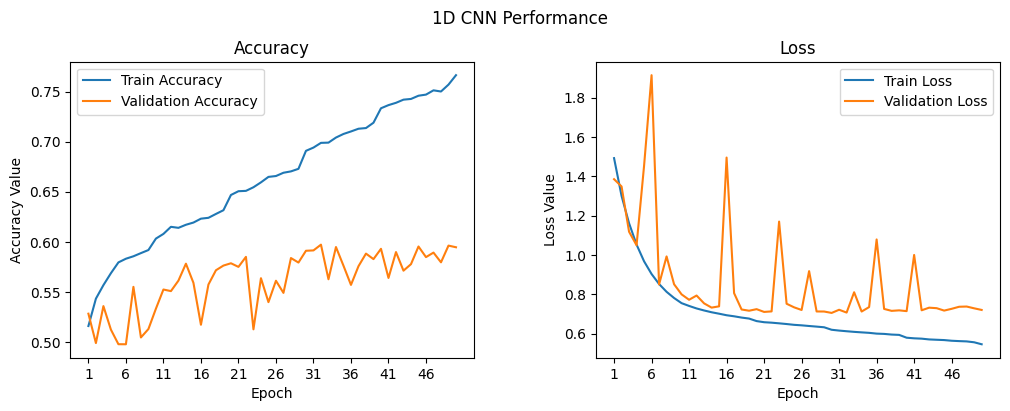

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('1D CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [35]:
cnn_model.evaluate(X_test, y_test)

107/107 [==============================] - 2s 15ms/step - loss: 0.7776 - accuracy: 0.5449


[0.7776341438293457, 0.5449207425117493]

## Classification Report

In [36]:
print(y_test)

[0. 0. 0. ... 0. 0. 0.]


In [37]:
from sklearn.metrics import classification_report, confusion_matrix
y_test_preds = np.around(cnn_model.predict(X_test))
# print(y_test_preds)

 10/107 [=>............................] - ETA: 0s 

2023-06-09 16:35:36.470476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


107/107 [==============================] - 1s 4ms/step


In [38]:
print(y_test_preds)

[[0.]
 [1.]
 [1.]
 ...
 [1.]
 [0.]
 [0.]]


In [39]:
y_test_preds.shape

(3406, 1)

In [40]:
import sklearn.metrics as metrics

In [41]:
print(metrics.classification_report(y_test, y_test_preds))

              precision    recall  f1-score   support

         0.0       0.55      0.52      0.53      1703
         1.0       0.54      0.57      0.56      1703

    accuracy                           0.54      3406
   macro avg       0.55      0.54      0.54      3406
weighted avg       0.55      0.54      0.54      3406



In [42]:
# reset_random_seeds()
# # kernel_regularizer =tf.keras.regularizers.l2(l=0.004)
# # initializer = tf.keras.initializers.HeUniform()
# cnn_model = tf.keras.models.Sequential()
# cnn_model.add(Conv1D(filters=5, kernel_size=(5,), padding='same',  activation='relu', input_shape= (X_train.shape[1],1)))
# cnn_model.add(BatchNormalization())
# cnn_model.add(MaxPool1D(pool_size=(2,), strides=2))
# cnn_model.add(BatchNormalization())
# cnn_model.add(Conv1D(filters=10, kernel_size=(5,), padding='same', activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.004)))
# cnn_model.add(BatchNormalization())
# cnn_model.add(MaxPool1D(pool_size=(2,), strides=2))
# cnn_model.add(BatchNormalization())
# cnn_model.add(Conv1D(filters=15, kernel_size=(5,), padding='same', activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.004)))
# cnn_model.add(BatchNormalization())
# cnn_model.add(MaxPool1D(pool_size=(2,), strides=2))
# cnn_model.add(BatchNormalization())
# cnn_model.add(Conv1D(filters=20, kernel_size=(5,), padding='same', activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.004)))
# cnn_model.add(BatchNormalization())
# cnn_model.add(MaxPool1D(pool_size=(2,), strides=2))
# cnn_model.add(BatchNormalization())
# cnn_model.add(Flatten())
# cnn_model.add(Dense(units = 128, activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.004)))
# cnn_model.add(Dense(units = 2, activation='softmax'))
# cnn_model.summary()